In [2]:
#데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요
!ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [3]:
# 1) 데이터 준비와 확인
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
# 2) 데이터로더 구성
'''
데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴
'''
from konlpy.tag import Mecab # 토큰화 하는 라이브러리
import numpy as np
from collections import Counter

tokenizer = Mecab() # 토크나이저 생성 # Mecab()은 형태소를 분석에 사용된다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):

    train_data.drop_duplicates(subset=['document'], inplace=True)       # (1)  
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # (1)
    # ['document']는 위의 표에서 댓글의 내용을 나타내는 시리즈(컬럼)이다.
    # duplicates() : 중복 여부 불리언 값을 시리즈로 반환한다.
    # drop.drop_dupicates() : 제거할 중복 값
    # subset = ['col']
    # keep='first' 중복 첫번째만 남기고 True를 반환, keep='last'마지막값을 제외하고 모두 True 반환
    # kepp=False 는 중복되는 모든 값을 True 반환
    # DataFrame.drop_duplicates(subset=['col'], keep='first', inplace=True)
    
    x_train = [] 
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    # x_train에 대한 라벨링 진행
    words = np.concatenate(x_train).tolist() 
    counter = Counter(words)   # (2)
    counter = counter.most_common(10000-4)  # (3)   
    # pre_vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']  # (4)
    vocab = [key for key, _ in counter]  # (5)
    word_to_index = {word:(index+4) for index, word in enumerate(vocab)}  # (6)
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3

    # (2)
    # collections.Counter(list) : list 요소들의 갯수를 딕셔너리 형태로 반환
    # collections.Counter(list).most_common(n) : list의 요소를 세어, 최빈값 n개를 리스트에 담긴 튜플형태로 반환
    # list.most_common() : 개수가 많은 순으로 정렬된 튜플 배열 리스트를 반환

    # (3)
    # 10000에서 4를 빼는 이유 : pre_vocab의 4개를 뺀 갯수
    
    # (4)
    # 지금은 vocab과 분리 해 둔다. 후에 vocab앞에 넣어준다.
    # 사실 지금 정의해 둘 필요는 없지만 어디에 뭐가 들어갈지 너어무 헷갈려서 미리 써둠

    # (5)
    # counter에 담긴 두 쌍의 튜플값에서 단어만 가지고 온다.
    
    # (6)
    # enumerate(list) : index와 해당 요소를 반환
    # (index+3) : 후에 vocab앞에 pre_vocab을 넣어야 하므로, 인덱스 번호를 4부터 시작하게 맞춰준다.
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] for word in wordlist if word in word_to_index]   
        
    x_train = list(map(wordlist_to_indexlist, x_train)) # (7)
    x_test = list(map(wordlist_to_indexlist, x_test))

    # (7)
    # list(map(함수이름, 함수에 들어갈 인자)) : map으로 함수를 실행시켜서 list로 반환
    # map(함수이름, 함수에 들어갈 인자) = 함수이름(인자)   
    
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    
    index_to_word = {index:word for word, index in word_to_index.items()}
        
    return x_train, y_train, x_test, y_test, word_to_index, index_to_word
            
    
x_train, y_train, x_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

# x_train, y_train, x_test, y_test, word_to_index, index_to_word을 모두 설정했다.

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


In [6]:
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [11]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence(x_train[10], index_to_word))
print('라벨: ', y_train[10])  # 1번째 리뷰데이터의 라벨

진짜 짱 다 ♥
라벨:  1


In [8]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
# 3) 모델 구성을 위한 데이터 분석 및 가공
'''
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
'''
total_data_text = x_train + x_test
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 약 %.2f퍼센트가 maxlen 설정값 이내에 포함됩니다.' % (np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.26729941281567
문장길이 최대 :  116
문장길이 표준편차 :  12.314845334104783
pad_sequences maxlen :  39
전체 문장의 약 0.93퍼센트가 maxlen 설정값 이내에 포함됩니다.


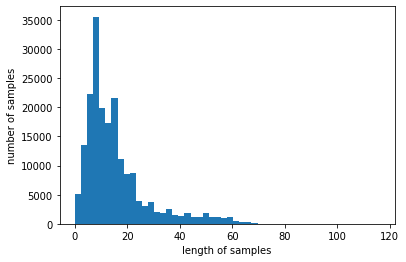

In [13]:
# 리뷰 길이 분포 확인
from matplotlib import pyplot as plt

plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 39)


In [15]:
# 4) 모델 구성 및 validation set 구성
#validation set은 5) 모델 학습때에 분리할 예정
import tensorflow as tf

In [16]:
# RNN 모델
# 임베딩사이즈는 (1, 10000, 4)이다.
# 단어사전의 갯수 10000개, 단어 하나당 4차원 벡터
# LSTM은 3차원을 입력값으로 받으므로, 3차원 배열로 임베딩 해준다.

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(10000, 36, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(16))
rnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 36)          360000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3392      
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 364,209
Trainable params: 364,209
Non-trainable params: 0
_________________________________________________________________


In [17]:
# CNN 모델
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(10000, 512, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(36, 3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(10))
cnn_model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(16, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         5120000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 36)          55332     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 36)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3488      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [18]:
# GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
# 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(10000, 32, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(16, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 320,545
Trainable params: 320,545
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 5) 모델 훈련 개시
print('학습용 데이터 전체 개수 :', len(x_train))
print('학습용 데이터 개수 ;', len(x_train)*0.7)
print('검증용 데이터 개수 :', len(x_train)*0.3)

'''x_train과 x_val을 7:3 비율로 나누어서 학습과 검증을 반복하도록 설정
모델을 학습하기에 앞서, model.compile() 메서드를 통해서 학습방식에 대한 설정을 해야한다.

optimizer(정규화기) : 최적화 알고리즘 설정
loss(손실함수) : 최적화에 사용되는 목적 함수
metrics(평가지표) : 분류에서는 accuracy, 회귀에서는 mse, rmse, r2, mae, mspe, mape, msle 등을 사용
verbose = 학습 중 출력되는 문구를 설정
0 : 아무 것도 출력하지 않는다.
1 : 훈련의 진행도를 보여주는 진행 막대를 보여준다.
2 : 미니 배치마다 손실 정보를 출력한다.
'''

학습용 데이터 전체 개수 : 146182
학습용 데이터 개수 ; 102327.4
검증용 데이터 개수 : 43854.6


'x_train과 x_val을 7:3 비율로 나누어서 학습과 검증을 반복하도록 설정\n모델을 학습하기에 앞서, model.compile() 메서드를 통해서 학습방식에 대한 설정을 해야한다.\n\noptimizer(정규화기) : 최적화 알고리즘 설정\nloss(손실함수) : 최적화에 사용되는 목적 함수\nmetrics(평가지표) : 분류에서는 accuracy, 회귀에서는 mse, rmse, r2, mae, mspe, mape, msle 등을 사용\nverbose = 학습 중 출력되는 문구를 설정\n0 : 아무 것도 출력하지 않는다.\n1 : 훈련의 진행도를 보여주는 진행 막대를 보여준다.\n2 : 미니 배치마다 손실 정보를 출력한다.\n'

In [21]:
rnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/20
200/200 [==============================] - 21s 9ms/step - loss: 0.5502 - accuracy: 0.6935 - val_loss: 0.3839 - val_accuracy: 0.8353
Epoch 2/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3418 - accuracy: 0.8545 - val_loss: 0.3658 - val_accuracy: 0.8384
Epoch 3/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3121 - accuracy: 0.8692 - val_loss: 0.3511 - val_accuracy: 0.8451
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 0.2945 - accuracy: 0.8758 - val_loss: 0.3517 - val_accuracy: 0.8471
Epoch 5/20
200/200 [==============================] - 1s 6ms/step - loss: 0.2773 - accuracy: 0.8817 - val_loss: 0.3752 - val_accuracy: 0.8379
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.2609 - accuracy: 0.8857 - val_loss: 0.3752 - val_accuracy: 0.8482
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 0.2496 - accuracy: 0.8893 - val_loss: 0.4085 - val_accuracy: 0.8481
Epoch

In [22]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/20
200/200 [==============================] - 13s 13ms/step - loss: 0.4254 - accuracy: 0.8027 - val_loss: 0.3483 - val_accuracy: 0.8488
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.2890 - accuracy: 0.8801 - val_loss: 0.3366 - val_accuracy: 0.8554
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 0.2141 - accuracy: 0.9168 - val_loss: 0.3638 - val_accuracy: 0.8523
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 0.1401 - accuracy: 0.9500 - val_loss: 0.4390 - val_accuracy: 0.8432
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0869 - accuracy: 0.9712 - val_loss: 0.5076 - val_accuracy: 0.8392
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0577 - accuracy: 0.9814 - val_loss: 0.5882 - val_accuracy: 0.8370
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0426 - accuracy: 0.9858 - val_loss: 0.6639 - val_accuracy: 0.835

In [23]:
GMP_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
GMP_history = GMP_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 0.5609 - accuracy: 0.7438 - val_loss: 0.4086 - val_accuracy: 0.8241
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3543 - accuracy: 0.8490 - val_loss: 0.3610 - val_accuracy: 0.8400
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3046 - accuracy: 0.8727 - val_loss: 0.3564 - val_accuracy: 0.8454
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2742 - accuracy: 0.8876 - val_loss: 0.3602 - val_accuracy: 0.8454
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.2503 - accuracy: 0.8991 - val_loss: 0.3687 - val_accuracy: 0.8451
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2290 - accuracy: 0.9091 - val_loss: 0.3818 - val_accuracy: 0.8430
Epoch 7/20
200/200 [==============================] - 1s 3ms/step - loss: 0.2100 - accuracy: 0.9189 - val_loss: 0.3989 - val_accuracy: 0.8412
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


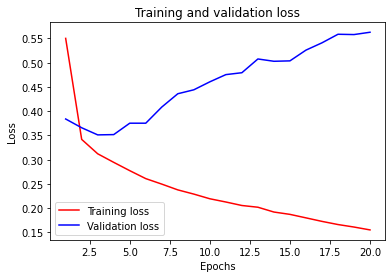

In [24]:
# 6) Loss, Accuracy 그래프 시각화
# RNN
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = rnn_history_dict['accuracy']
val_acc = rnn_history_dict['val_accuracy']
loss = rnn_history_dict['loss']
val_loss = rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


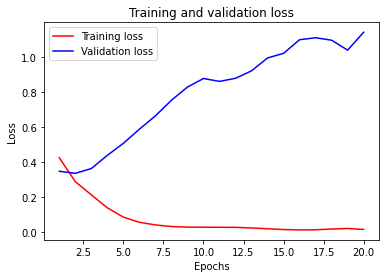

In [25]:
# CNN
cnn_history_dict = cnn_history.history
print(cnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


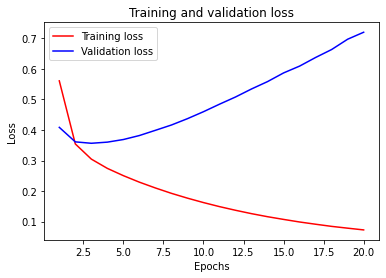

In [26]:
# GlobalMaxPooling1D()
GMP_history_dict = GMP_history.history
print(GMP_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
results_1 = rnn_model.evaluate(x_test,  y_test, verbose=2)
results_2 = cnn_model.evaluate(x_test,  y_test, verbose=2)
results_3 = GMP_model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.5688 - accuracy: 0.8358
1537/1537 - 3s - loss: 1.1466 - accuracy: 0.8256
1537/1537 - 2s - loss: 0.7127 - accuracy: 0.8176


In [29]:
# 7) 학습된 Embedding 레이어 분석
!mkdir -p ~/aiffel/sentiment_classification/data
!pip list | grep gensim

gensim                        4.1.2


In [30]:
#RNN
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(rnn_weights.shape)   

(10000, 36)


In [31]:
import os

vocab_size = rnn_weights.shape[0]
rnn_word_vector_dim = rnn_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, rnn_word_vector_dim))

8

In [32]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

In [33]:
#CNN
cnn_embedding_layer = cnn_model.layers[0]
cnn_weights = cnn_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(cnn_weights.shape)    

(10000, 512)


In [34]:
vocab_size = rnn_weights.shape[0]
cnn_word_vector_dim = cnn_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')

In [35]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
cnn_vectors = cnn_model.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(cnn_vectors[i, :])))))
f.close()

In [36]:
#GlobalMaxPooling1D()
GMP_embedding_layer = GMP_model.layers[0]
GMP_weights = GMP_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(GMP_weights.shape)    

(10000, 32)


In [37]:
vocab_size = GMP_weights.shape[0]
GMP_word_vector_dim = GMP_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')

In [38]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
GMP_vectors = GMP_model.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(GMP_vectors[i, :])))))
f.close()

In [41]:
# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
!pip freeze

absl-py==0.12.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1637087032947/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
albumentations==1.1.0
antlr4-python3-runtime==4.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1637703202493/work/dist
appdirs==1.4.4
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1636021379509/work
astunparse==1.6.3
async-generator==1.10
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1637092647930/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1620387926260/work
audioread==2.1.9
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4==4.6.0
black==21.12b0
bleach @ file:///home/conda/feedstock_root/build_artifacts/ble

In [42]:
!pip uninstall gensim --yes
!pip install gensim==3.8.3

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2
     |████████████████████████████████| 23.4 MB 5.6 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=2a4b9c244bf8ec53d03bfc785b7aaf8c545bd9dbfaebded5a799c6d6ce785c2d
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim


In [56]:
import os
from gensim.models import Word2Vec

In [67]:
from tensorflow.keras.initializers import Constant

# LSTM 레이어로 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model.add(tf.keras.layers.Dropout(0.25))                    # Dropout 추가
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))                     # Dropout 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 39, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
____________________________________________

In [68]:
# 학습의 진행
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train,y_train, epochs=5, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/5
200/200 [==============================] - 4s 16ms/step - loss: 0.6935 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/5
200/200 [==============================] - 3s 13ms/step - loss: 0.6929 - accuracy: 0.5012 - val_loss: 0.6925 - val_accuracy: 0.5018
Epoch 3/5
200/200 [==============================] - 3s 13ms/step - loss: 0.6922 - accuracy: 0.5047 - val_loss: 0.6916 - val_accuracy: 0.5085
Epoch 4/5
200/200 [==============================] - 3s 13ms/step - loss: 0.6904 - accuracy: 0.5130 - val_loss: 0.6933 - val_accuracy: 0.4982
Epoch 5/5
200/200 [==============================] - 3s 13ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5018


In [69]:
results = model.evaluate(x_test,  y_test, verbose=2)
results

1537/1537 - 3s - loss: 0.6932 - accuracy: 0.4973


[0.6931515336036682, 0.4973045587539673]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


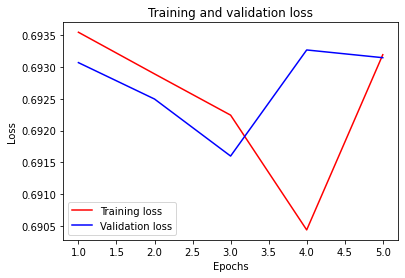

In [70]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()